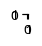

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, PairedVAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [2]:
# Load models together
from src.torch_utils import load_model_full
from src.metrics import compute_cosine_distance
from src.utils import get_class_initcode_keys
from src.models import BimodalVAEClassifier, FullTCRVAE, PeptideClassifier
from src.datasets import BimodalTCRpMHCDataset, FullTCRDataset, LatentTCRpMHCDataset, TCRSpecificDataset
from src.train_eval import predict_bimodal, predict_model
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
pos_df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
mix_df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')


def get_model(folder):
    pt = glob.glob(folder+'/*.pt')[0]
    js = glob.glob(folder+'/*.json')[0]
    model = load_model_full(pt, js, return_json=False, verbose=False)
    return model
    

# do heatmap for retrained model

In [3]:
from src.datasets import BimodalTCRpMHCDataset
# dataset_bimodal = BimodalTCRpMHCDataset(mix_df, 0, 0, 22, 0, 0, 23, encoding='BL50LO', pad_scale=-20,  pep_encoding='BL50LO', pep_pad_scale=-20)
# dataset_a3b3 = FullTCRDataset(pos_df, 0, 0, 22, 0, 0, 23, encoding='BL50LO', pad_scale=-20)
# dataset_full = FullTCRDataset(pos_df, 7, 8, 22, 6, 7, 23, encoding='BL50LO', pad_scale=-20)
dataset_bimodal_full = BimodalTCRpMHCDataset(mix_df, 7,8, 22, 6, 7, 23, encoding='BL50LO', pad_scale=-20, pep_encoding='BL50LO', pep_pad_scale=-20)
loader_bimodal_full = dataset_bimodal_full.get_dataloader(1024, SequentialSampler)
# loader_bimodal = dataset_bimodal.get_dataloader(1024, SequentialSampler)
# loader_a3b3 = dataset_a3b3.get_dataloader(1024, SequentialSampler)
# loader_full = dataset_full.get_dataloader(1024, SequentialSampler)

In [4]:
# here, check the predictions using the new model trained with smaller margin and longer warmup
model = get_model('../output/240115_twostageFullTCR_WarmUpLowerMargin2Kepochs_KFold_1_240115_1401_TIGHT/')
predictions = predict_bimodal(model, dataset_bimodal_full, loader_bimodal_full)
predictions['model_fold']=1
predictions['set'] = predictions.apply(lambda x: 'train' if x['model_fold']!=x['partition'] else 'valid', axis=1)

MLP metrics: auc: 0.943	auc_01: 0.856	auc_01_real: 0.727	precision: 0.800	accuracy: 0.923	AP: 0.841


In [14]:
binders = predictions.query('binder==1')
z = torch.from_numpy(binders[[x for x in binders.columns if x.startswith('z_')]].values)
distances = compute_cosine_distance(z)

In [28]:
preds_sorted = binders.sort_values('peptide').reset_index(drop=True)
zcols = [x for x in preds_sorted.columns if x.startswith('z_')]
dist_sorted = compute_cosine_distance(torch.from_numpy(preds_sorted[zcols].values))

Text(0.5, 1.0, 'Sorted heatmap (By peptide)')

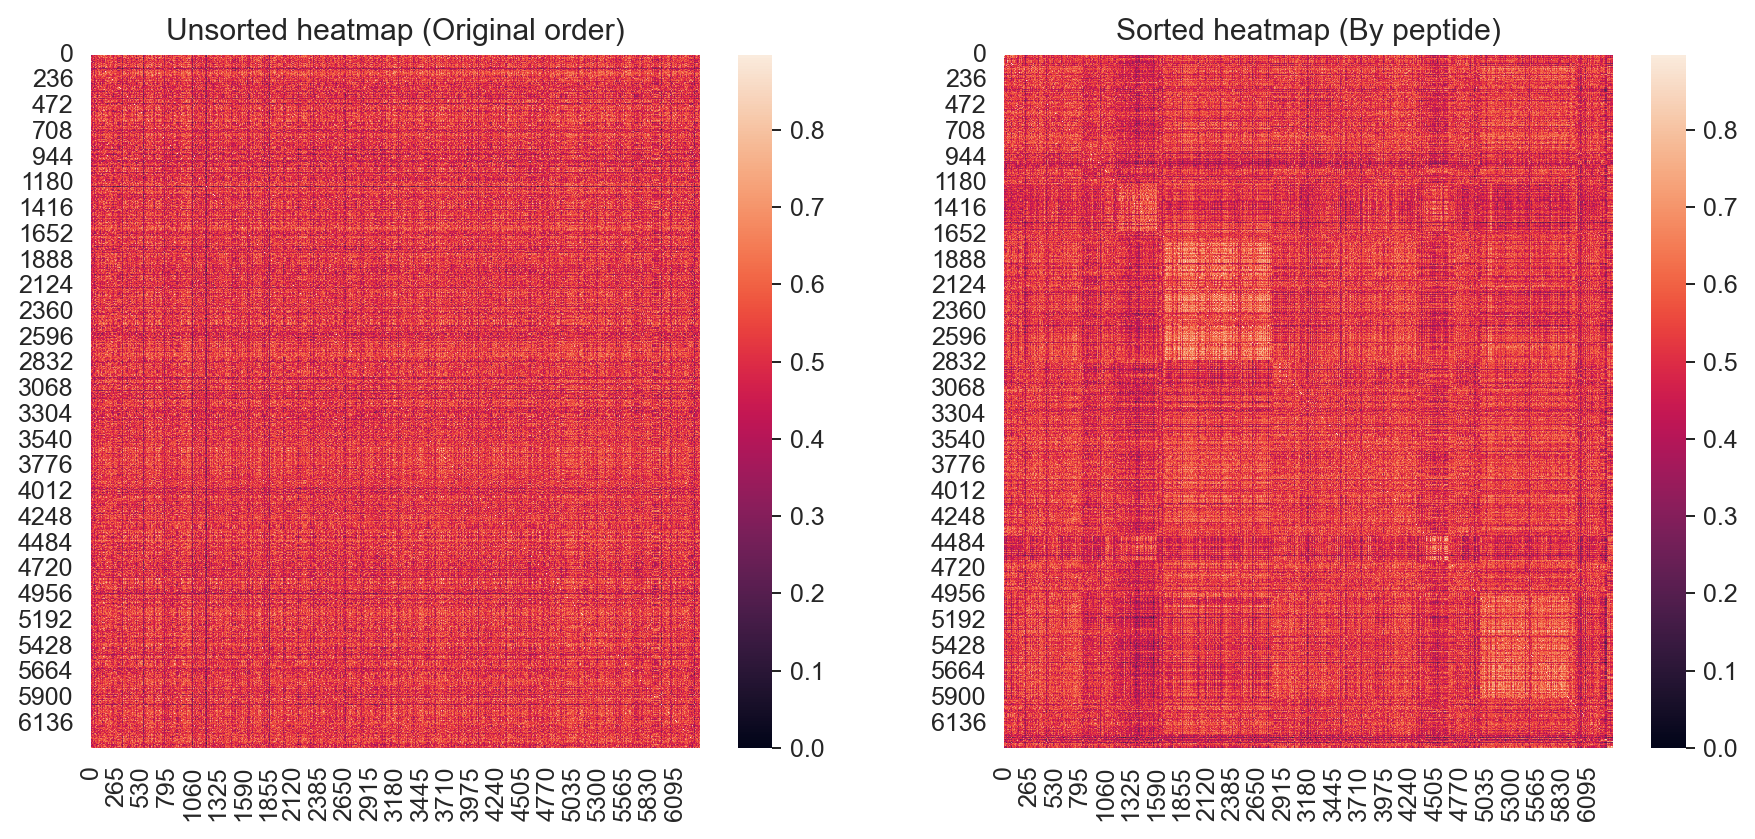

In [29]:
sort_by_pep = pos_df.reset_index(drop=True).sort_values('peptide').index.values
mve = distances.max().item()

f,a = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(data= mve - distances, ax = a[0])
a[0].set_title('Unsorted heatmap (Original order)')
sns.heatmap(data= mve - dist_sorted, ax = a[1])
a[1].set_title('Sorted heatmap (By peptide)')


Text(0.5, 1.0, 'Sorted heatmap (By peptide)')

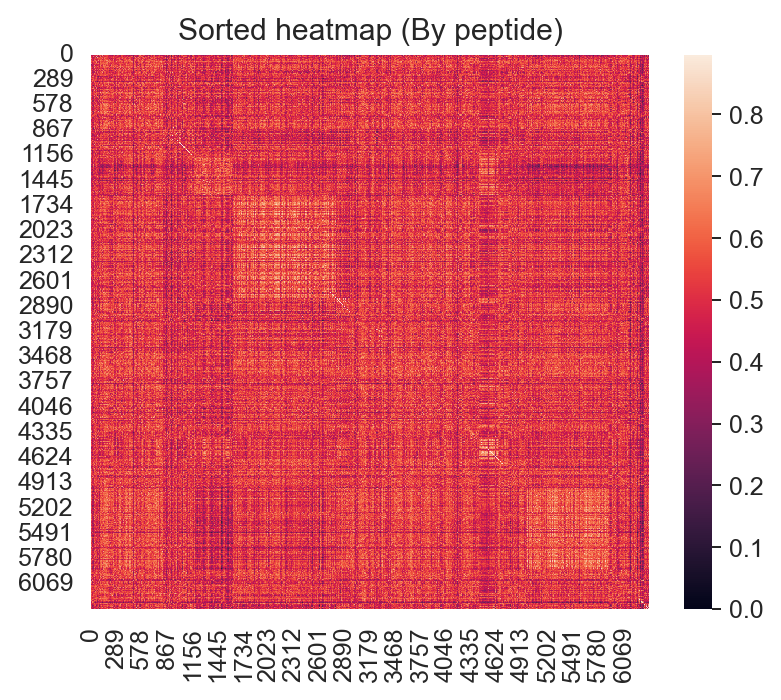

In [31]:
f, a = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(data= mve - dist_sorted, ax = a)
a.set_title('Sorted heatmap (By peptide)')


# New dataset

## Adding Peptide sequence

In [14]:
# Here, best approach seems to be just modifying FullTCRDataset for now 
from src.datasets import FullTCRDataset

tcrpep_dataset = FullTCRDataset(pos_df, 0, 0, 0, 0, 0, 23, 12)
tcrpep_dataset.x.shape

torch.Size([6353, 700])

## Adding positional and/or length encoding

In [ ]:
class TestDs(VAEDataset):

    def __init__(self, df, max_len_a1, max_len_a2, max_len_a3, max_len_b1, max_len_b2, max_len_b3, max_len_pep=0,
                 encoding='BL50LO', pad_scale=None, a1_col='A1', a2_col='A2', a3_col='A3', b1_col='B1', b2_col='B2',
                 b3_col='B3', pep_col='original_peptide', add_positional_encoding=True, pep_weighted=False, pep_weight_scale=3.8):
        super(FullTCRDataset, self).__init__()
        # TODO : Current behaviour If max_len_x = 0, then don't use that chain...
        #        Is that the most elegant way to do this ?
        assert not all([x == 0 for x in [max_len_a1, max_len_a2, max_len_a3,
                                         max_len_b1, max_len_b2, max_len_b3]]), \
            'All loops max_len are 0! No chains will be added'

        x_seq = []
        self.max_len_a1 = max_len_a1
        self.max_len_a2 = max_len_a2
        self.max_len_a3 = max_len_a3
        self.max_len_b1 = max_len_b1
        self.max_len_b2 = max_len_b2
        self.max_len_b3 = max_len_b3
        self.max_len_pep = max_len_pep
        self.use_a1 = not (max_len_a1 == 0)
        self.use_a2 = not (max_len_a2 == 0)
        self.use_a3 = not (max_len_a3 == 0)
        self.use_b1 = not (max_len_b1 == 0)
        self.use_b2 = not (max_len_b2 == 0)
        self.use_b3 = not (max_len_b3 == 0)
        self.use_pep = not (max_len_pep == 0)

        # bad double loop because brain slow
        for max_len, seq_col in zip([max_len_a1, max_len_a2, max_len_a3, max_len_b1, max_len_b2, max_len_b3, max_len_pep],
                                    [a1_col, a2_col, a3_col, b1_col, b2_col, b3_col, pep_col]):
            if max_len != 0:
                df['len_q'] = df[seq_col].apply(len)
                df = df.query('len_q <= @max_len')
        for max_len, seq_col in zip([max_len_a1, max_len_a2, max_len_a3, max_len_b1, max_len_b2, max_len_b3, max_len_pep],
                                    [a1_col, a2_col, a3_col, b1_col, b2_col, b3_col, pep_col]):
            if max_len != 0:
                encoded = encode_batch(df[seq_col], max_len, encoding, pad_scale)
                x_seq.append(encoded.flatten(start_dim=1))

        self.df = df.drop(columns=['len_q']).reset_index(drop=True)
        self.x = torch.cat(x_seq, dim=1)
        self.pep_weighted = pep_weighted
        # Here save a weight that is peptide specific to give more/less importance to peptides that are less/more frequent
        if pep_weighted:
            pepweights = np.log2(len(self.df) / self.df.groupby(['peptide']).agg(count=(f'{b3_col}', 'count')))
            self.pep_weights = torch.from_numpy(
                self.df.apply(lambda x: pepweights.loc[x['peptide']], axis=1).values / pep_weight_scale).flatten(
                start_dim=0)
        else:
            self.pep_weights = torch.ones([len(self.x)])


In [36]:
pd.set_option('display.max_columns', 22)
sample = pos_df.sample(5, random_state=13)
cols = list(filter(lambda x: len(x)==2, sample.columns)) + ['peptide']
maxlens = {k:v for (k,v) in zip(cols,[7,8,22,6,7,23, 12]) }
for c in cols:
    sample[f'len_{c}'] = sample[c].apply(len)
    sample[f'fl_{c}'] = sample.apply(lambda x: x[f'len_{c}'] / maxlens[c], axis=1)

sample[cols + [f'len_{c}' for c in cols] + [f'fl_{c}' for c in cols]]

A1        A2             A3     B1       B2            B3  \
2609   TSINN   IRSNERE   ATDPDTGRRALT  SGHDT   YYEEEE   ASSLLIREAYT   
684   DRGSQS    IYSNGD    AVSIGFGNVLH  MNHEY   SMNVEV  ASSGRAGTGVQF   
3283  NSASQS     VYSSG     VVNSYGQNFV  KGHDR   SFDVKD  ATSDRLAGGELF   
765   VSGNPY  YITGDNLV  ASPGGGGSQGNLI  LNHDA   SQIVND   ASRKRGTAPQF   
838    TSINN   IRSNERE   ATDSGGSNYKLT  SQVTM  ANQGSEA   SVGAGEDDEQY   

         peptide  len_A1  len_A2  len_A3  len_B1  len_B2  len_B3  len_peptide  \
2609   KLGGALQAK       5       7      12       5       6      11            9   
684   ELAGIGILTV       6       6      11       5       6      12           10   
3283   KLGGALQAK       6       5      10       5       6      12            9   
765    GILGFVFTL       6       8      13       5       6      11            9   
838     RAKFKQLL       5       7      12       5       7      11            8   

         fl_A1  fl_A2     fl_A3     fl_B1     fl_B2     fl_B3  fl_peptide  
2609  0.714286  0.875  0.545455  0.833333  0.857143  0.478261    0.750000  
684   0.857143  0.750  0.500000  0.833333  0.857143  0.521739    0.833333  
3283  0.857143  0.625  0.454545  0.833333  0.857143  0.521739    0.750000  
765   0.857143  1.000  0.590909  0.833333  0.857143  0.478261    0.750000  
838   0.714286  0.875  0.545455  0.833333  1.000000  0.478261    0.666667

In [37]:
def positional_encode(seq, pad = (0, 0)):
    return F.pad(torch.ones([len(seq)]), pad = (pad[0], pad[1]-len(seq)))

def batch_positional_encode(seqs, pad = (0, 0)):
    return torch.stack([positional_encode(seq, pad) for seq in seqs])

In [145]:
from src.data_processing import encode_batch
cols = list(filter(lambda x: len(x)==2, sample.columns)) + ['peptide']

maxlens = {k:v for (k,v) in zip(cols,[7,8,22,6,7,23, 12])}
maxlensvalues = list([maxlens[k] for k in selected])
selected = ['A1', 'A3', 'B3', 'peptide']
pads = {k:(sum(maxlensvalues[:i]), sum(maxlensvalues)-sum(maxlensvalues[:i]) ) for i,k in enumerate(selected)}

pos_encodings = []
seq_1 = []
seq_2 = []
for c in selected:
    seq_1.append(encode_batch(sample[c], maxlens[c], encoding='BL50LO', pad_scale=-20))
    seq_2.append(encode_batch(sample[c], maxlens[c], encoding='BL50LO', pad_scale=-20).flatten(start_dim=1))
    pos_encodings.append(batch_positional_encode(sample[c], pads[c]))

In [137]:
# This is what is in the current dataset implementation before flattening for dim 1
flat_cat = torch.cat(seq_1, axis=1).flatten(start_dim=1)
flat_pos = torch.stack(pos_encodings,axis=2).flatten(start_dim=1)

In [138]:
flat_cat.shape, flat_pos.shape

(torch.Size([5, 1280]), torch.Size([5, 256]))

In [151]:
lin = nn.Linear(20, 50)
seq_cat = torch.cat(seq_1,axis=1)
seq_flat = seq_cat.flatten(start_dim=1)


In [152]:
from src.models import FullTCRVAE
model = FullTCRVAE(7, 0, 22, 0, 0, 23, 12)

In [154]:
model.slice_x(seq_flat)[0].shape

torch.Size([5, 64, 20])

In [149]:
seq_cat.shape

torch.Size([5, 64, 20])

In [129]:
seq_cat = torch.cat(seq_cat,axis=1)

torch.Size([5, 64, 20])

## Handling unlabelled data (?)

## Custom batching to group datapoints with same peptide specificity? 